In [22]:
import netCDF4 as nc
import glob
import numpy as np
import datetime
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats
import math
from datetime import date

In [25]:
dt_parse = '%Y%m'
def get_date_num(stri):
    date1 = datetime.datetime.strptime(stri, dt_parse)
    return(date.toordinal(date1.date()))
list_of_paths = glob.glob('C:/Users/Patrick/Desktop/175_final/global_fwi_analysis/FWI_nc\'s/*.nc', recursive=True)
nc_list = []
nc_date_list = []
nc_date_key = []
nc_date_int = []
for path in list_of_paths:
    nc_list.append(nc.Dataset(path))
    nc_date_list.append(get_date_num(path[-9:-3]))
    nc_date_key.append(path[-9:-3])

In [34]:
normed_date = np.round(np.array(nc_date_list) - np.mean(np.array(nc_date_list)))
print(len(normed_date))


476


In [24]:
fwi = []
for i in nc_list:
    fwi.append(i['MERRA2_FWI'][0])
fwi_array = np.dstack(fwi)

<ipython-input-24-9e0b1f9b52d8>:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  fwi.append(i['MERRA2_FWI'][0])
<ipython-input-24-9e0b1f9b52d8>:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  fwi.append(i['MERRA2_FWI'][0])


In [ ]:
years = list(range(1985, 2019))
for i in range(len(years)):
    years[i] = str(years[i])
print(years)
yearly_list = []

for year in years:
    temp_array_list = []
    for i in range(476):
        if(nc_date_key[i][0:4] == year):
            temp_array_list.append(fwi_array[:,:,i])
    print(len(temp_array_list))
    avg_array = np.empty((267,576))
    avg_array[:] = np.nan
    for j in range(267):
        for k in range(576):
            point_list = []
            for q in range(len(temp_array_list)):
                point_list.append(temp_array_list[q][j,k])
            avg_array[j,k] = np.nanmean(np.array(point_list))
    yearly_list.append(avg_array)

In [10]:
year_from_start = np.array(list(range(34)))
yearly_array = np.dstack(yearly_list)

In [52]:
t_trend_slope = np.empty([267, 576])
t_trend_intercept = np.empty([267, 576])
t_trend_rvalue = np.empty([267, 576])
t_trend_pvalue = np.empty([267, 576])
t_trend_stderr = np.empty([267, 576])

t_fwi_point = np.empty([476])
for i in range(267):
    for j in range(576):
        t_fwi_point = fwi_array[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(t_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(t_fwi_point) & ~np.isnan(normed_date)
            t_trend_slope[i,j], t_trend_intercept[i,j], t_trend_rvalue[i,j], t_trend_pvalue[i,j], t_trend_stderr[i,j] = stats.linregress(normed_date[mask], t_fwi_point[mask])
        else:
            t_trend_slope[i,j] = np.float('NaN')
            t_trend_pvalue[i,j] = np.float('NaN')
            
fwi_detrend = np.empty((267, 576, 476))
for i in range(476):
    fwi_detrend[:,:,i] = fwi_array[:,:,i] - normed_date[i]*t_trend_slope[:,:]        

<ipython-input-52-faa5476ef3b4>:12: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(t_fwi_point)))):


In [48]:
print(len(difference(fwi_detrend[200,150,:], 360)))

116


In [53]:
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
fwi_re_season = np.empty([267, 576, 464]) 
for i in range(267):
    for j in range(576):
        fwi_re_season[i,j,:] = difference(fwi_detrend[i,j],12)

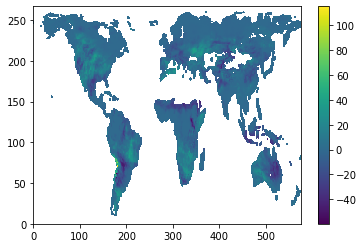

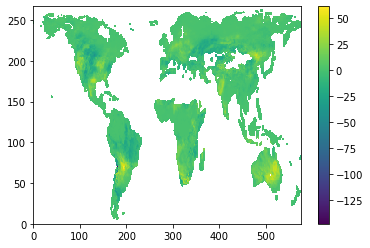

In [57]:
plt.figure(1)
plt.pcolormesh(fwi_re_season[:,:,200])
plt.colorbar()
plt.figure(2)
plt.pcolormesh(fwi_re_season[:,:,212])
plt.colorbar()

In [13]:
ONI = np.genfromtxt('oni.csv', delimiter=',')[0]

o_trend_slope, o_trend_intercept, o_trend_rvalue, o_trend_pvalue, o_trend_stderr = stats.linregress(year_from_start, ONI)
print(o_trend_slope, o_trend_pvalue)
ONI_detrend = ONI - o_trend_slope*year_from_start
#plt.plot(ONI_detrend)

-0.0026292335220779216 0.8167984690873058


In [16]:
forest_cover = np.genfromtxt('deforestation.csv', delimiter = ',')
forest_cover_array = forest_cover[0]
deforestation = forest_cover_array - np.nanmean(forest_cover_array)

d_trend_slope, d_trend_intercept, d_trend_rvalue, d_trend_pvalue, d_trend_stderr = stats.linregress(year_from_start, deforestation)
#print(d_trend_slope, d_trend_pvalue)
deforestation_detrend = deforestation - d_trend_slope*year_from_start
#plt.plot(amazon_detrend)

In [20]:
coef_ONI = np.empty([267, 576])

oni_fwi_point = np.empty([34])
for i in range(267):
    for j in range(576):
        oni_fwi_point = yearly_fwi_detrend[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(oni_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(oni_fwi_point) & ~np.isnan(ONI_detrend)
            coef_ONI[i,j] = (np.corrcoef(ONI_detrend[mask], oni_fwi_point[mask]))[0,1]
        else:
            coef_ONI[i,j] = np.float('NaN')

coef_deforestation = np.empty([267, 576])

df_fwi_point = np.empty([34])
for i in range(267):
    for j in range(576):
        df_fwi_point = yearly_fwi_detrend[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(df_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(df_fwi_point) & ~np.isnan(deforestation_detrend)
            coef_deforestation[i,j] = (np.corrcoef(deforestation_detrend[mask], df_fwi_point[mask]))[0,1]
        else:
            coef_deforestation[i,j] = np.float('NaN')

<ipython-input-20-fa8c87095873>:8: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(oni_fwi_point)))):
<ipython-input-20-fa8c87095873>:22: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(df_fwi_point)))):


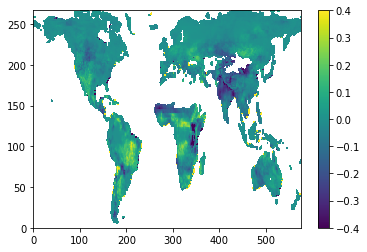

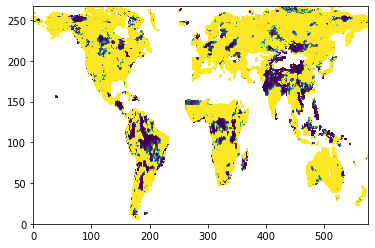

In [39]:
plt.figure(1)
plt.pcolormesh(t_trend_slope*365.25, vmin=-0.4, vmax=0.4)
plt.colorbar()
plt.figure(2)
plt.pcolormesh(t_trend_pvalue, vmin=0, vmax=0.05)
plt.colorbar()
plt.figure(3)
plt.pcolormesh(coef_ONI, vmin=-1, vmax=1)
plt.colorbar()
#plt.figure(4)
#plt.pcolormesh(coef_deforestation, vmin=-1, vmax=1)
#plt.colorbar()